# 1. Projeto Dashboard Covid

O projeto utiliza dados de casos e mortes da John Hopkins University armazenados no GitHub pelo repositório [CSSE (JHU)](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports). Como este repositório não contem dados de vacinação, é usado o projeto *Our World in Data* (OWID) da Universidade de Oxford pelo link [OWID](https://ourworldindata.org/). Os dados passaram por uma limpeza para reunir apenas o período de 2021 e somente os estados do Brasil.

A meta do projeto foi desenvolver um *dashboard* implementado no **Google Looker Studio**. Nele, foram exibidos alguns **indicadores-chave de desempenho** (KPI, *key performance indicators*) como número diário de casos e mortes, médias móveis de 7 dias e tendências, organizados por um seletor de data. 

Além disso, foram adicionados gráficos incluindo **séries temporais** dos casos e mortes no ano de 2021 pelo Brasil todo. Também foi adicionado um gráfico contendo a evolução da população neste mesmo período. Por fim, o *dashboard* contém um mapa do Brasil com valores de casos diários seguindo um mapa de cor, divididos por estado.

# 2. ETL (extração, transformação e carregamento)

## 2.1 - Casos e mortes

In [1]:
import math
from typing import Iterator
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns

Começamos importando as bibliotecas de interesse. Vamos precisar extrair os dados particionados por dia da JHU contendo as informações de casos e mortes. Definimos uma função geradora para devolver os objetos *datetime* de dias do ano de 2021.

In [2]:
def date_range(start_date: datetime, end_date: datetime) -> Iterator[datetime]:
    date_range_days: int = (end_date - start_date).days
    for lag in range(date_range_days):
        yield start_date + timedelta(lag)

In [3]:
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31)

Então fazemos um laço de repetição lendo cada arquivo por dia, contendo informações de vários países e regiões no mundo. Então, a cada execução do laço concatenamos estes DataFrames juntos, até capturar as informações do ano de 2021 todo. A URL dos dados contém datas no formato '%m-%d-%Y' enquanto objetos *datetime* seguem forma '%Y-%m-%d'. 

São removidas colunas como FIPS, Admin2 que se referem mais a dados dos EUA, entre outras como Lat, Long_, Recovered, Active e outras que não são de interesse. Filtramos também para a região 'Brazil' usando `DataFrame.query()`, assim só teremos dados dos estados e do Brasil ao todo.

```
cases = None
cases_is_empty = True

for date in date_range(start_date=start_date, end_date=end_date):
    date_str = date.strftime('%m-%d-%Y') # formato do GitHub do JHU
    data_source_url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{date_str}.csv'

    caso = pd.read_csv(data_source_url, sep=',')
    caso = caso.drop(['FIPS', 'Admin2', 'Last_Update', 'Lat', 'Long_', 'Recovered', 'Active', 'Combined_Key', 'Case_Fatality_Ratio'], axis=1)
    caso = caso.query('Country_Region == "Brazil"').reset_index(drop=True)
    caso['Date'] = pd.to_datetime(date.strftime('%Y-%m-%d'))

    if cases_is_empty:
        cases = caso
        cases_is_empty = False
    else:
        cases = pd.concat([cases, caso], ignore_index=True)
        
print('Finalizado!')
```

In [4]:
cases = pd.read_csv('../input/owid-dataset/cases-raw.csv', sep=',', parse_dates=[5])

Podemos conferir os dados para algumas regiões, como São Paulo.

In [5]:
cases.query('Province_State == "Sao Paulo"').head()

,Province_State,Country_Region,Confirmed,Deaths,Incident_Rate,Date
24,Sao Paulo,Brazil,1466191,46775,3192.990778,2021-01-01
51,Sao Paulo,Brazil,1467953,46808,3196.827966,2021-01-02
78,Sao Paulo,Brazil,1471422,46845,3204.382565,2021-01-03
105,Sao Paulo,Brazil,1473670,46888,3209.278136,2021-01-04
132,Sao Paulo,Brazil,1486551,47222,3237.329676,2021-01-05


E ver informações de formato, tipos de dados e colunas do DataFrame.

In [6]:
cases.shape

(9828, 6)

In [7]:
cases.columns

Index(['Province_State', 'Country_Region', 'Confirmed', 'Deaths',
       'Incident_Rate', 'Date'],
      dtype='object')

In [8]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9828 entries, 0 to 9827
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province_State  9828 non-null   object        
 1   Country_Region  9828 non-null   object        
 2   Confirmed       9828 non-null   int64         
 3   Deaths          9828 non-null   int64         
 4   Incident_Rate   9828 non-null   float64       
 5   Date            9828 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 460.8+ KB


Vamos então renomear algumas colunas de forma a simplificar, e deixar tudo minúsculo por padrão.

In [9]:
cases = cases.rename(
    columns = {
        'Province_State': 'state',
        'Country_Region': 'country'
    }
)

for col in cases.columns:
    cases = cases.rename(columns = {
        col: col.lower()
    })

In [10]:
cases.columns

Index(['state', 'country', 'confirmed', 'deaths', 'incident_rate', 'date'], dtype='object')

Vamos também deixar os valores dos estados padronizados com acentos para facilitar a integração com o Google Looker Studio. Desta forma, a visualização por mapa vai ficar consistente.

In [11]:
states_map = {
    'Amapa': 'Amapá',
    'Ceara': 'Ceará',
    'Espirito Santo': 'Espírito Santo',
    'Goias': 'Goiás',
    'Para': 'Pará',
    'Paraiba': 'Paraíba',
    'Parana': 'Paraná',
    'Piaui': 'Piauí',
    'Rondonia': 'Rondônia',
    'Sao Paulo': 'São Paulo'
}

cases['state'] = cases['state'].apply(lambda x: states_map[x] if x in states_map.keys() else x)

cases['state'].unique()

array(['Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará',
       'Distrito Federal', 'Espírito Santo', 'Goiás', 'Maranhao',
       'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Pará',
       'Paraíba', 'Paraná', 'Pernambuco', 'Piauí', 'Rio Grande do Norte',
       'Rio Grande do Sul', 'Rio de Janeiro', 'Rondônia', 'Roraima',
       'Santa Catarina', 'São Paulo', 'Sergipe', 'Tocantins'],
      dtype=object)

Vamos adicionar as chaves temporais de mês e ano, e também a população estimada usando a coluna `incident_rate` que dá o número de casos por 100 mil habitantes.

In [12]:
cases['month'] = cases['date'].apply(lambda x: x.strftime('%Y-%m'))
cases['year'] = cases['date'].apply(lambda x: x.strftime('%Y'))

In [13]:
cases['population'] = (100000 * cases['confirmed'] / cases['incident_rate'])
cases = cases.drop('incident_rate', axis=1)
cases.columns

Index(['state', 'country', 'confirmed', 'deaths', 'date', 'month', 'year',
       'population'],
      dtype='object')

Agora, vamos enriquecer os dados com alguns cálculos. No caso, vamos adicionar colunas sobre casos diários, média móvel de 7 dias, estabilidade de 14 dias e tendência. O mesmo para os dados de mortes.

In [14]:
cases_ = None
cases_is_empty = True

def get_trend(rate: float) -> str:
    if np.isnan(rate):
        return np.NaN

    if rate < 0.75:
        status = 'downward'
    elif rate > 1.15:
        status = 'upward'
    else:
        status = 'stable'

    return status

for state in cases['state'].drop_duplicates():
    cases_per_state = cases.query(f'state == "{state}"').reset_index(drop=True)
    cases_per_state = cases_per_state.sort_values(by=['date'])
    
    # Cálculos para os casos
    cases_per_state['confirmed_1d'] = cases_per_state['confirmed'].diff(periods=1)
    cases_per_state['confirmed_moving_avg_7d'] = cases_per_state['confirmed_1d'].rolling(window=7).mean()
    cases_per_state['confirmed_moving_avg_7d_rate_14d'] = cases_per_state['confirmed_moving_avg_7d']/cases_per_state['confirmed_moving_avg_7d'].shift(periods=14)
    cases_per_state['confirmed_trend'] = cases_per_state['confirmed_moving_avg_7d_rate_14d'].apply(get_trend)
    
    # Cálculos para as mortes
    cases_per_state['deaths_1d'] = cases_per_state['deaths'].diff(periods=1)
    cases_per_state['deaths_moving_avg_7d'] = cases_per_state['deaths_1d'].rolling(window=7).mean()
    cases_per_state['deaths_moving_avg_7d_rate_14d'] = cases_per_state['deaths_moving_avg_7d']/cases_per_state['deaths_moving_avg_7d'].shift(periods=14)
    cases_per_state['deaths_trend'] = cases_per_state['deaths_moving_avg_7d_rate_14d'].apply(get_trend)

    # Concatenação dos dados por estado
    if cases_is_empty:
        cases_ = cases_per_state
        cases_is_empty = False
    else:
        cases_ = pd.concat([cases_, cases_per_state], ignore_index=True)

# Novo DataFrame com novas colunas de métricas
cases = cases_

In [15]:
cases.tail()

,state,country,confirmed,deaths,date,month,year,population,confirmed_1d,confirmed_moving_avg_7d,confirmed_moving_avg_7d_rate_14d,confirmed_trend,deaths_1d,deaths_moving_avg_7d,deaths_moving_avg_7d_rate_14d,deaths_trend
9823,Tocantins,Brazil,234113,3927,2021-12-26,2021-12,2021,1572866.0,0.0,0.000000,0.000000,downward,0.0,0.000000,0.0,downward
9824,Tocantins,Brazil,234113,3927,2021-12-27,2021-12,2021,1572866.0,0.0,0.000000,0.000000,downward,0.0,0.000000,0.0,downward
9825,Tocantins,Brazil,234964,3933,2021-12-28,2021-12,2021,1572866.0,851.0,121.571429,2.846154,upward,6.0,0.857143,6.0,upward
9826,Tocantins,Brazil,235340,3936,2021-12-29,2021-12,2021,1572866.0,376.0,175.285714,inf,upward,3.0,1.285714,inf,upward
9827,Tocantins,Brazil,235558,3939,2021-12-30,2021-12,2021,1572866.0,218.0,206.428571,inf,upward,3.0,1.714286,inf,upward


Com o Seaborn podemos visualizar esses dados. Por exemplo, a quantidade de casos diários no estado de São Paulo pelo tempo em 2021.

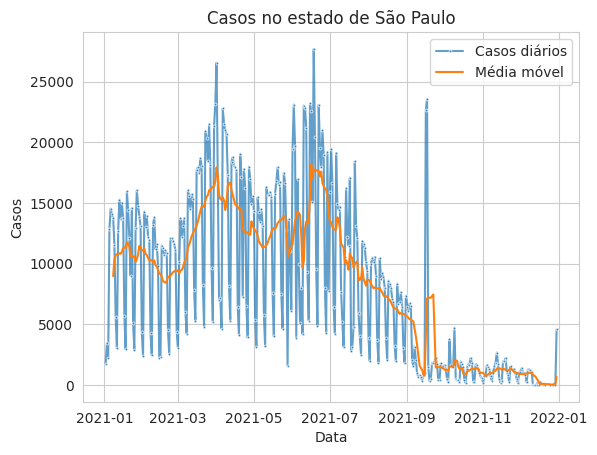

In [16]:
with sns.axes_style('whitegrid'):
    fig = sns.lineplot(data=cases.query('state == "São Paulo"'), x='date', y='confirmed_1d', marker='o', markersize=2, alpha=0.7, label='Casos diários')
    fig = sns.lineplot(data=cases.query('state == "São Paulo"'), x='date', y='confirmed_moving_avg_7d', label='Média móvel')
    fig.set(title='Casos no estado de São Paulo', xlabel='Data', ylabel='Casos')

Os dados de população apresentam poucas variações por cada estado, em geral. Porém, podemos visualizar a evolução da população do Brasil pelo tempo em 2021, o que pode ser útil para contrastar com os casos e mortes.

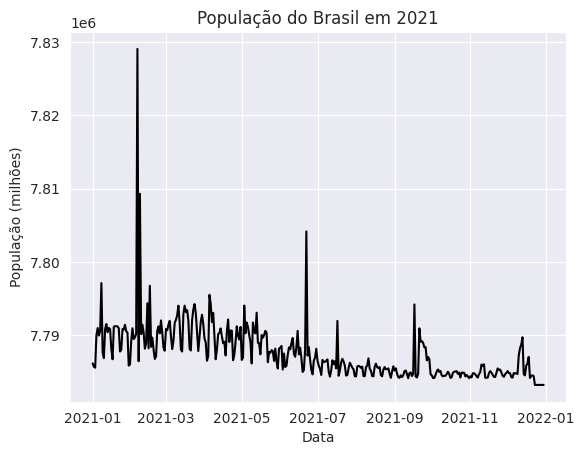

In [17]:
with sns.axes_style('darkgrid'):
    fig = sns.lineplot(data=cases, x='date', y='population', errorbar=None, color='black')
    fig.set(title='População do Brasil em 2021', xlabel='Data', ylabel='População (milhões)')

## 2.2 - Vacinações (OWID)

Os dados de vacinação também precisam ser extraídos e passar por uma etapa de limpeza. O arquivo CSV original contém muitas colunas, das quais são retiradas poucas com dados sobre população, 1.ª dose, 2.ª dose e assim por diante. Também é feito um filtro para obter apenas os dados do Brasil.

In [18]:
vaccines = pd.read_csv('../input/owid-dataset/owid-covid-data.csv', sep=',', parse_dates=[3], infer_datetime_format=True)
vaccines.head()

/tmp/ipykernel_20/1368462406.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  vaccines = pd.read_csv('../input/owid-dataset/owid-covid-data.csv', sep=',', parse_dates=[3], infer_datetime_format=True)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [19]:
vaccines.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [20]:
vaccines = vaccines.query('location == "Brazil"').reset_index(drop=True)
vaccines = vaccines[['location', 'population', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'date']]

In [21]:
vaccines.head()

,location,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,date
0,Brazil,215313504.0,NaN,NaN,NaN,NaN,2020-01-03
1,Brazil,215313504.0,NaN,NaN,NaN,NaN,2020-01-04
2,Brazil,215313504.0,NaN,NaN,NaN,NaN,2020-01-05
3,Brazil,215313504.0,NaN,NaN,NaN,NaN,2020-01-06
4,Brazil,215313504.0,NaN,NaN,NaN,NaN,2020-01-07


In [22]:
vaccines.shape

(1385, 7)

In [23]:
vaccines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   location                 1385 non-null   object        
 1   population               1385 non-null   float64       
 2   total_vaccinations       695 non-null    float64       
 3   people_vaccinated        691 non-null    float64       
 4   people_fully_vaccinated  675 non-null    float64       
 5   total_boosters           455 non-null    float64       
 6   date                     1385 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 75.9+ KB


O DataFrame contém dados faltantes, como pode ser visto pelo método `DataFrame.isna().any()`. O método escolhido para preencher estes valores é o `DataFrame.fillna()` com *forward fill*. Ou seja, os buracos são preenchidos com o valor anterior válido mais próximo.

In [24]:
vaccines.isna().any()

location                   False
population                 False
total_vaccinations          True
people_vaccinated           True
people_fully_vaccinated     True
total_boosters              True
date                       False
dtype: bool

In [25]:
vaccines = vaccines.fillna(method='ffill')

O período de tempo também é filtrado para conter apenas os dados de 2021.

In [26]:
vaccines = vaccines[(vaccines['date'] >= '2021-01-01') & (vaccines['date'] <= '2021-12-31')].reset_index(drop=True)

In [27]:
vaccines.shape

(365, 7)

Renomeamos as colunas com nomes padronizados e minúsculos, para facilitar a posterior etape de *dashboard*.

In [28]:
vaccines = vaccines.rename(
    columns={
        'location': 'country',
        'total_vaccinations': 'total',
        'people_vaccinated': 'one_shot',
        'people_fully_vaccinated': 'two_shots',
        'total_boosters': 'three_shots'
    }
)

In [29]:
vaccines.columns

Index(['country', 'population', 'total', 'one_shot', 'two_shots',
       'three_shots', 'date'],
      dtype='object')

Adicionamos novamente as colunas temporais e mês e ano. Além disso, colocamos colunas de percentual dos tipos de vacinação com 1, 2 ou 3 doses, dividindo pelos dados de população.

* Chaves temporais:

In [30]:
vaccines['month'] = vaccines['date'].apply(lambda x: x.strftime('%Y-%m'))
vaccines['year'] = vaccines['date'].apply(lambda x: x.strftime('%Y'))

* Dados relativos:

In [31]:
vaccines['one_shot_perc'] = round(vaccines['one_shot'] / vaccines['population'], 4)
vaccines['two_shots_perc'] = round(vaccines['two_shots'] / vaccines['population'], 4)
vaccines['three_shots_perc'] = round(vaccines['three_shots'] / vaccines['population'], 4)

In [32]:
vaccines.head()

,country,population,total,one_shot,two_shots,three_shots,date,month,year,one_shot_perc,two_shots_perc,three_shots_perc
0,Brazil,215313504.0,NaN,NaN,NaN,NaN,2021-01-01,2021-01,2021,NaN,NaN,NaN
1,Brazil,215313504.0,NaN,NaN,NaN,NaN,2021-01-02,2021-01,2021,NaN,NaN,NaN
2,Brazil,215313504.0,NaN,NaN,NaN,NaN,2021-01-03,2021-01,2021,NaN,NaN,NaN
3,Brazil,215313504.0,NaN,NaN,NaN,NaN,2021-01-04,2021-01,2021,NaN,NaN,NaN
4,Brazil,215313504.0,NaN,NaN,NaN,NaN,2021-01-05,2021-01,2021,NaN,NaN,NaN


Para garantir a consistência dos dados, checamos os tipos dos dados fazendo um *type casting*.

In [33]:
vaccines['population'] = vaccines['population'].astype('Int64')
vaccines['total'] = vaccines['total'].astype('Int64')
vaccines['one_shot'] = vaccines['one_shot'].astype('Int64')
vaccines['two_shots'] = vaccines['two_shots'].astype('Int64')
vaccines['three_shots'] = vaccines['three_shots'].astype('Int64')

In [34]:
vaccines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   country           365 non-null    object        
 1   population        365 non-null    Int64         
 2   total             349 non-null    Int64         
 3   one_shot          349 non-null    Int64         
 4   two_shots         330 non-null    Int64         
 5   three_shots       121 non-null    Int64         
 6   date              365 non-null    datetime64[ns]
 7   month             365 non-null    object        
 8   year              365 non-null    object        
 9   one_shot_perc     349 non-null    float64       
 10  two_shots_perc    330 non-null    float64       
 11  three_shots_perc  121 non-null    float64       
dtypes: Int64(5), datetime64[ns](1), float64(3), object(3)
memory usage: 36.1+ KB


Por fim, reorganizamos a ordem das colunas para gerar o DataFrame final.

In [35]:
vaccines = vaccines[['date', 'month', 'year', 'country', 'population', 'total', 'one_shot', 'one_shot_perc', 'two_shots', 'two_shots_perc', 'three_shots', 'three_shots_perc']]

Podemos visualizar como ficam os dados dos tipos de doses (uma dose, imunização completa e dose de reforço) no Brasil em 2021, novamente usando o Seaborn.

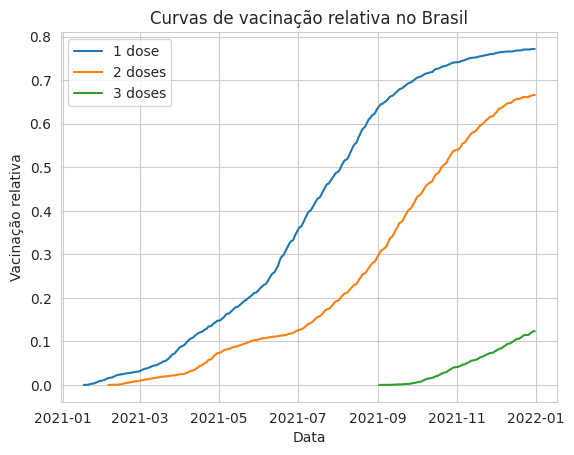

In [36]:
with sns.axes_style('whitegrid'):
    fig = sns.lineplot(data=vaccines, x='date', y='one_shot_perc', label='1 dose')
    fig = sns.lineplot(data=vaccines, x='date', y='two_shots_perc', label='2 doses')
    fig = sns.lineplot(data=vaccines, x='date', y='three_shots_perc', label='3 doses')
    fig.set(title='Curvas de vacinação relativa no Brasil', xlabel='Data', ylabel='Vacinação relativa')

Então carregamos os dados de casos/mortes e vacinações para serem utilizados no Google Looker Studio.

In [37]:
cases.to_csv('../working/covid-cases.csv', sep=',', index=False)
vaccines.to_csv('../working/covid-vaccines.csv', sep=',', index=False)

# 3. Dashboard

Utilizando o Google Looker Studio, são carregadas as fontes de dados dos arquivos covid-cases.csv e covid-vaccines.csv. Em ambas são conferidos os campos de tipos de dados, usando funções como `PARSE_DATA('%Y-%m', month)` para criar um novo campo `month_parsed` que segue o formato `date` adequadamente.

São adicionadas KPI's (*key performance indicators*) mostrando os casos e mortes diários, a média móvel de 7 dias e a tendência desses dados. Isto tudo é organizado usando uma lista suspensa com a coluna de datas por dia. Também é utilizado um mapa colorido preenchido para os dados de casos diários por cada estado do Brasil, que podem ser selecionados.

Por último, são acrescentados gráficos de séries temporais dos casos diários com média móvel, das mortes diárias com sua média móvel e também da população do Brasil. Eles são destacados a nível de relatório, e não de página, para não serem alterados pelo seletor temporal de data.

<img src='https://github.com/mateus-miguel/projeto-dashboard-covid/blob/main/img/dashboard_covid_population.png?raw=true'/>